### Flight Purchase Recommendation Model:

In this pricing recommendation model, every flight is supposed to have its own distribution of prices as it relates to time. A flight will be "scored" with prices from the pricing model to simulate the pricing curve until two weeks before departure. If the current price falls in the bottom 20% of pricing curve by rank order then a recommendation is generated to "buy" the flight; otherwise the recommendation is generated to "wait" to purchase. 
<br>
<br>
I began with an EDA of a single trip's historical pricing data to familarize myself with the distributions of the flight prices and potential features. For a first pass regression model, I chose a Random Forest regression algorithm to predict flight prices as a first pass due to its nature of avoiding overfitting with minimal hyperparameter tuning. Next, I reviewed each sample data column to generate about 40 potential features. I excluded quite a few datetime features to ensure that time trend feature "advance" would be adequately captured as a predictor. Otherwise, changing the advance feature for price simulations might undercapture the actual sensitivity to changes in the time up until flight departure. My holdout lift curve and RMSE metric suggest that the model predicts surprisingly well with little tuning, but care should be taken to ensure absolutely no data leakage has occurred. Running the last cell will select a random flight, generate a pricing curve, and provide a purchase recommendation. 
<br>
<br>
If I continued this project, I'd spend more time running more traditional time series analysis, such as ACF and PACF plots. I'd also build an ARIMA model and test the accuracy using a more novel method, such as Facebook's Prophet tool or a variational time series LSTM. An ARIMA might fit the pricing data worse than a random forest, but parametric models such as ARIMA are often more robust to simulating changes such as the "advance" time trend in this model.

### Columns:

- search_id: the bundle identifer 
- trip_index: the index of the trip within a bundle
- received_date: date the trip was received
- received_ms: epoch milliseconds trip was received
- origin: origin airport
- destination: destination airport
- total_usd: total fare including taxes and fees
- pax_type: passenger type quoted
- refundable: refundable fare indicator
- validating_carrier: airline selling the ticket
- departure_odate: departure date in origin TZ
- departure_ms: epoch milliseconds of departure
- outgoing_duration: total in minutes 
- outgoing_stops: number of stops on outbound trip
- return_odate: return date in destination TZ
- return_ms: epoch millis of return time
- returning_duration: total in minutes
- returning_stops: number of stops on return trip
- major_carrier_id: airline delivering majority of flight time
- total_stops: total stops for round-trip
- advance: days search before departure
- length_of_stay: nights between departure and return
- includes_saturday_night_stay: indicator for saturday stayover (pred)
- available_seats: quoted availability at search time (pred?)
- lowest_cabin_class: lowest cabin class over all flights (pred)
- highest_cabin_class: highest cabin class over all flights (pred)



## I. Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import date
from datetime import datetime
import timeit

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.base import TransformerMixin
from sklearn.utils import resample
from sklearn.externals import joblib

In [2]:
flights = pd.read_csv(r'price/longitudinal_trim.csv')


In [41]:
flights_sample = flights.iloc[0:1000]
flights_sample.to_csv(r'price/sample.csv')

## II. EDA

In [269]:
# search_id.columns
flights_sample.head()

,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,...,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class
0,f079363a-b281-3476-b13e-d96ba6a8ad8a,11,2016-04-21,1461268013357,BOS,CUN,397.0,ADT,NaN,AM,...,615,1,AM,2,42,4,True,8,E,E
1,f079363a-b281-3476-b13e-d96ba6a8ad8a,15,2016-04-21,1461268013357,BOS,CUN,412.8,ADT,NaN,UA,...,492,1,UA,2,42,4,True,8,E,E
2,f079363a-b281-3476-b13e-d96ba6a8ad8a,17,2016-04-21,1461268013357,BOS,CUN,412.8,ADT,NaN,UA,...,526,1,UA,2,42,4,True,8,E,E
3,f079363a-b281-3476-b13e-d96ba6a8ad8a,19,2016-04-21,1461268013357,BOS,CUN,412.8,ADT,NaN,UA,...,405,1,UA,2,42,4,True,8,E,E
4,f079363a-b281-3476-b13e-d96ba6a8ad8a,29,2016-04-21,1461268013357,BOS,CUN,412.8,ADT,NaN,UA,...,526,1,UA,2,42,4,True,9,E,E


In [351]:
flights['refundable'].value_counts()

Series([], Name: refundable, dtype: int64)

In [12]:
len(set(flights.search_id))
# avg 3 count per unique search IDs
#
search_id = flights.groupby(['search_id'])['search_id'].count()

print(search_id.shape)
search_id.head(20)

(113339,)


search_id
00017fed-4c3b-3721-9d52-d3def47b94d2    20
00027d0e-c5bf-3a7c-b515-34b1290d61c7    22
00028d9a-e0eb-3a5f-b2ee-136972976547    18
0003d6d6-2200-3120-b5f1-4149ab8ac710    22
00042e4d-7b62-3402-b613-2d7b7c7b4ea4    18
00048743-8fa3-3f28-921f-8f0aa85a2bb6    23
00049ffd-69ef-3e5e-ba6d-375bf887e869    21
0004ae06-6982-3eef-885a-e2cd2191ba71    24
00051e35-2c0e-3cf2-b31f-686411ee5282    23
00057273-512b-3285-b07b-c3bccabf79cd    24
00057740-5226-33d1-aa84-ac9f33683373     7
0005b838-000d-38d7-a768-8e7a3bc28f28    18
0005bace-949a-30e3-a042-a22fbe9fa6f0    19
0005e31d-ce4e-33bc-ae8b-e17e166213c2    24
00069189-50d7-3a23-a92a-2dacdefeee73    20
00078bb5-c5bc-3d64-b594-5982d9f90e5c    21
00082080-3261-3722-a39b-8efac4acae53    21
000875de-42c3-3a30-b2c7-9e0e1bd2120a    17
000963fc-8fe8-343e-a666-9902eeaad4eb    16
0009f3be-da1d-3675-8c99-89425350a0ca    26
Name: search_id, dtype: int64

### Plot distribution of "search_id" counts:

Distribution of Search ID Counts:


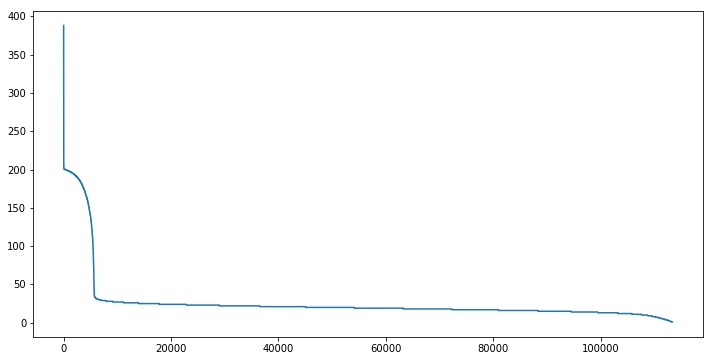

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c5f46a0>]],
      dtype=object)

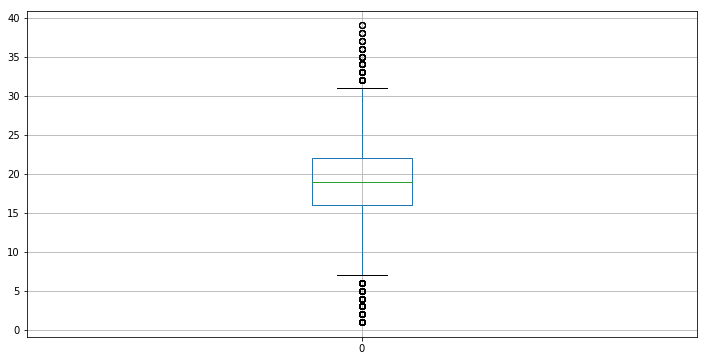

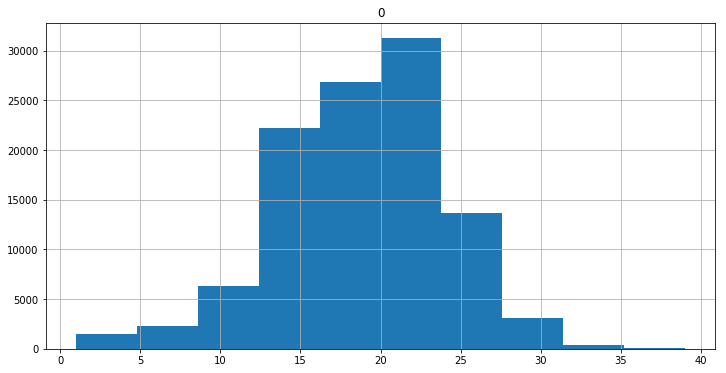

In [244]:
search_id_plot = -np.sort(-search_id)
plt.plot(search_id_plot)
print("Distribution of Search ID Counts:")
plt.show()

search_id_box = search_id_plot[np.where(search_id_plot < 40)]
pd.DataFrame(search_id_box).boxplot()
pd.DataFrame(search_id_box).hist()

### Plot Distribution of Flight Prices Under Differing Thresholds:

Distribution of Flight Prices Under $2000


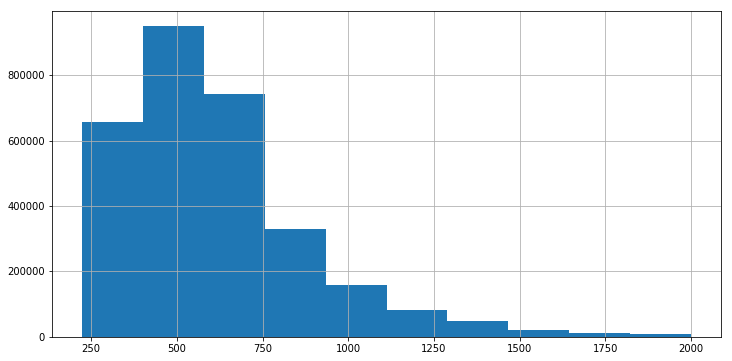

Distribution of Flight Prices Under $1000


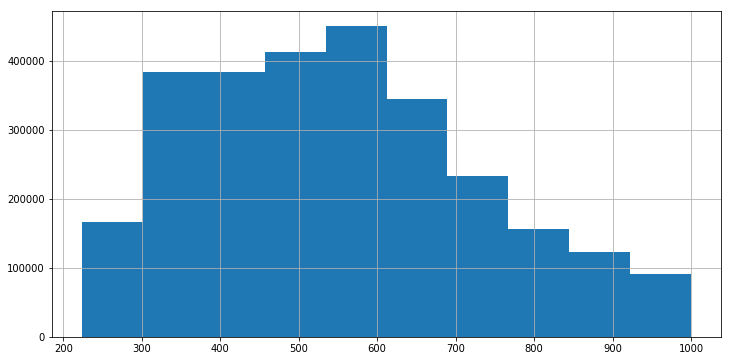

In [522]:
print("Distribution of Flight Prices Under $2000")
flights[flights['total_usd'] < 2000]['total_usd'].hist()
plt.show()
print("Distribution of Flight Prices Under $1000")
flights[flights['total_usd'] < 1000]['total_usd'].hist()
plt.show()

In [65]:
flight_cats = flights.loc[:,
                        ['pax_type','refundable'
                          ,'origin','destination','validating_carrier'
                      ,'major_carrier_id','returning_stops','advance','length_of_stay'
                      ,'includes_saturday_night_stay','available_seats','lowest_cabin_class'	
                      ,'highest_cabin_class']]
for i in flight_cats.columns:
    print(flight_cats[i].value_counts(dropna=False))

ADT    2654847
NaN     354561
Name: pax_type, dtype: int64
NaN    3009408
Name: refundable, dtype: int64
BOS    3009408
Name: origin, dtype: int64
CUN    3009408
Name: destination, dtype: int64
UA     1178400
AA     1007558
NaN     354561
DL      243238
AM       77353
B6       69392
AC       61270
NK       11328
WS        4517
SY        1147
CM         548
VX          37
HR          34
AS          16
AV           9
Name: validating_carrier, dtype: int64
UA    1312751
AA    1007568
DL     418983
B6      87316
AM      86142
AC      71135
NK      13039
WS      10101
SY       1194
CM       1098
VX         59
AS         22
Name: major_carrier_id, dtype: int64
1    2628510
2     291102
0      88348
3       1448
Name: returning_stops, dtype: int64
4      34397
3      33480
2      32266
6      30945
1      30054
14     29206
5      28984
7      28488
31     27132
15     26536
24     26028
30     24756
44     24610
10     23919
16     23539
22     23414
12     23210
21     23145
8      23144
25

In [67]:
flights.columns

Index(['search_id', 'trip_index', 'received_date', 'received_ms', 'origin',
       'destination', 'total_usd', 'pax_type', 'refundable',
       'validating_carrier', 'departure_odate', 'departure_ms',
       'outgoing_duration', 'outgoing_stops', 'return_odate', 'return_ms',
       'returning_duration', 'returning_stops', 'major_carrier_id',
       'total_stops', 'advance', 'length_of_stay',
       'includes_saturday_night_stay', 'available_seats', 'lowest_cabin_class',
       'highest_cabin_class'],
      dtype='object')

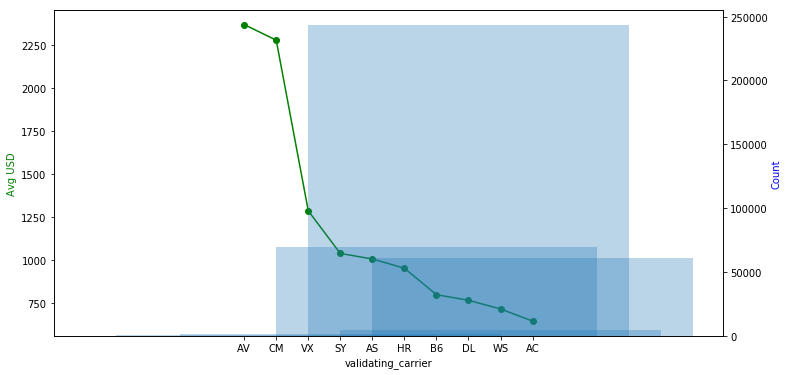

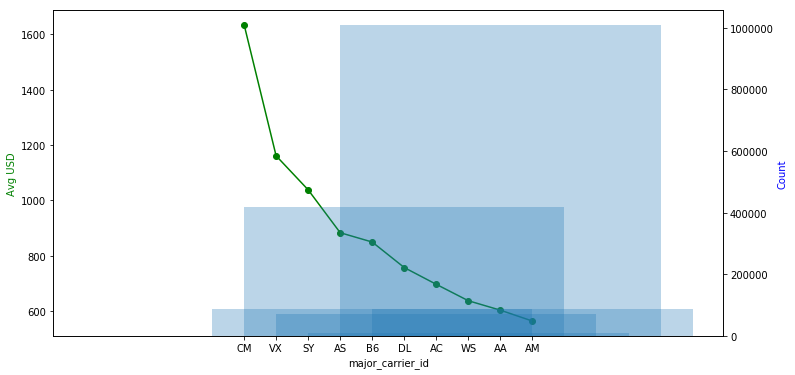

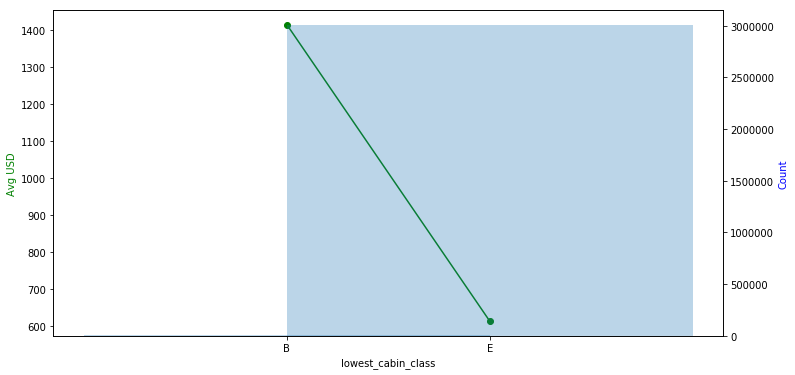

In [243]:
# Univariate 
uni_cols = ['validating_carrier'
#             ,'advance'
#             ,'includes_saturday_night_stay'
#             ,'length_of_stay'
            ,'major_carrier_id'
            ,'lowest_cabin_class'
#             ,'total_stops'
           ]


for col in uni_cols:
    flights_group1 = flights.groupby(col,sort=False)[col,'total_usd'].agg({
        'count': 'count',
        'mean': 'mean'})
    flights_group1.columns = [col,'count','total_usd_mean']
    flights_group2 = flights_group1.sort_values('total_usd_mean',ascending=False)

    x_bar = flights_group2[col].index[0:10]
    y_bar = flights_group2['count'][0:10]
    y_line = flights_group2['total_usd_mean'][0:10]

    y_line = flights_group2['total_usd_mean'][0:10]

    y1 = flights_group2[col].index[0:10]
    y2 = flights_group2['count'][0:10]

    fig, ax1 = plt.subplots()
    ind = [x for x, _ in enumerate(x_bar)]

    ax2 = ax1.twinx()
    ax2.bar(y1, y2, 'b-',alpha=0.3)
    ax1.plot(y1, y_line, 'g-',marker='o')

    ax1.set_xlabel(col)
    ax1.set_ylabel('Avg USD', color='g')
    ax2.set_ylabel('Count', color='b')

    plt.show()

## III. Create Time Features and Prepare Other Variables


Using 700k flights as a representative sample

In [470]:
flights_test = flights.sample(700000)

flights_test['pax_type_full'] = flights['pax_type'].fillna('missing')
flights_test['pax_type_full'].value_counts()

ADT        617153
missing     82847
Name: pax_type_full, dtype: int64

In [471]:
#Past price features - if we have time, create a timeline of all prices for every historical day for each airline

historical_prices = flights.groupby(
    ['received_date','departure_odate'
     ,'return_odate','major_carrier_id','departure_ms','return_ms'
    ]
)['total_usd'].agg({'max':'max'
                  ,'min':'min'
                  ,'mean':'mean'})

len(historical_prices)
# price_ratio_1_days = 
# price_ratio_7_days = 
# price_ratio_30_days = 
# price_ratio_90_days = 
# price_ratio_180_days = 

/Users/Tanner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


2013425

In [472]:
historical_prices.sample(10)

,,,,,,max,min,mean
received_date,departure_odate,return_odate,major_carrier_id,departure_ms,return_ms,,,
2016-12-28,2017-01-01,2017-01-04,UA,1483269300000,1483563900000,432.68,432.68,432.68
2016-08-17,2016-11-05,2016-11-12,AA,1478370780000,1478969700000,502.52,502.52,502.52
2016-12-12,2016-12-30,2017-01-05,AA,1483095600000,1483647000000,358.18,358.18,358.18
2016-01-28,2016-04-12,2016-04-19,B6,1460458860000,1461086580000,600.69,600.69,600.69
2016-09-24,2017-02-22,2017-03-05,AM,1487805240000,1488728880000,430.19,430.19,430.19
2016-02-24,2016-05-06,2016-05-09,UA,1462537440000,1462818900000,506.39,506.39,506.39
2016-02-11,2016-07-01,2016-07-05,UA,1467367200000,1467753300000,512.39,512.39,512.39
2016-10-27,2017-03-11,2017-03-18,UA,1489246500000,1489838400000,449.93,449.93,449.93
2016-10-17,2017-01-13,2017-01-17,AC,1484321400000,1484671200000,429.73,429.73,429.73


In [473]:
print(flights['received_date'].head())
print(flights['departure_odate'].head())
print(flights['return_odate'].head())

date_columns = ['received_date','departure_odate','return_odate']


flights_test['received_date_dt'] = flights_test['received_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
flights_test['departure_date_dt'] = flights_test['departure_odate'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
flights_test['return_date_dt'] = flights_test['return_odate'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

0    2016-04-21
1    2016-04-21
2    2016-04-21
3    2016-04-21
4    2016-04-21
Name: received_date, dtype: object
0    2016-06-02
1    2016-06-02
2    2016-06-02
3    2016-06-02
4    2016-06-02
Name: departure_odate, dtype: object
0    2016-06-06
1    2016-06-06
2    2016-06-06
3    2016-06-06
4    2016-06-06
Name: return_odate, dtype: object


In [537]:
flights_test['days_until_return'] = (flights_test['return_date_dt'] - flights_test['received_date_dt'])
flights_test['days_until_return'].head()

test = flights_test['days_until_return']/ np.timedelta64(1, 'D')
test[0:10]

334658      98.0
55393      120.0
1533805     55.0
1847985     39.0
2474636     37.0
997276      21.0
2318358    259.0
956303      20.0
1562437     21.0
1745155     52.0
Name: days_until_return, dtype: float64

### Prepare date variables:

In [538]:
# If we had more time, using received_ms we could bring in hour, minute as cyclical continuous features 
# using sin function, or create a "time of day" bucket (e.g., morning, evening, etc.)

# days until departure should already be defined with "advance", but doing manual check
flights_test['days_until_departure'] = (flights_test['departure_date_dt'] - flights_test['received_date_dt'])
flights_test['days_until_departure'] = flights_test['days_until_return']/ np.timedelta64(1, 'D')

# flights_test['days_until_departure'] = flights_test['days_until_departure'].astype('int')
flights_test['days_until_return'] = (flights_test['return_date_dt'] - flights_test['received_date_dt'])
flights_test['days_until_return'] = flights_test['days_until_return']/ np.timedelta64(1, 'D')
# flights_test['days_until_return'] = flights_test['days_until_return'].astype('int')

def weekend(x):
    if x >= 5:
        return 1
    else:      
        return 0

flights_test['received_date_year'] = flights_test['received_date_dt'].dt.year
flights_test['received_date_quarter'] = flights_test['received_date_dt'].dt.quarter
flights_test['received_date_month'] = flights_test['received_date_dt'].dt.month
flights_test['received_date_week'] = flights_test['received_date_dt'].dt.week
flights_test['received_date_day'] = flights_test['received_date_dt'].dt.day
flights_test['received_date_day_of_week'] = flights_test['received_date_dt'].dt.dayofweek
flights_test['received_date_week_of_year'] = flights_test['received_date_dt'].dt.weekofyear
flights_test['received_date_weekend_flag'] = flights_test['received_date_day_of_week'].apply(weekend) 

flights_test['departure_date_year'] = flights_test['departure_date_dt'].dt.year
flights_test['departure_date_quarter'] = flights_test['departure_date_dt'].dt.quarter
flights_test['departure_date_month'] = flights_test['departure_date_dt'].dt.month
flights_test['departure_date_week'] = flights_test['departure_date_dt'].dt.week
flights_test['departure_date_day'] = flights_test['departure_date_dt'].dt.day
flights_test['departure_date_day_of_week'] = flights_test['departure_date_dt'].dt.dayofweek
flights_test['departure_date_week_of_year'] = flights_test['departure_date_dt'].dt.weekofyear
flights_test['departure_date_weekend_flag'] = flights_test['departure_date_day_of_week'].apply(weekend)

flights_test['return_date_year'] = flights_test['return_date_dt'].dt.year
flights_test['return_date_quarter'] = flights_test['return_date_dt'].dt.quarter
flights_test['return_date_month'] = flights_test['return_date_dt'].dt.month
flights_test['return_date_week'] = flights_test['return_date_dt'].dt.week
flights_test['return_date_day'] = flights_test['return_date_dt'].dt.day
flights_test['return_date_day_of_week'] = flights_test['return_date_dt'].dt.dayofweek
flights_test['return_date_week_of_year'] = flights_test['return_date_dt'].dt.weekofyear
flights_test['return_date_weekend_flag'] = flights_test['return_date_day_of_week'].apply(weekend)

# flights_test['return_date_day_of_week'].value_counts()
# flights_test['return_date_day'].value_counts()

# flights_test['days_until_return'].value_counts()
# flights_test['days_until_departure'].value_counts()

## IV. Begin RF Model

### Define Features:

In [546]:
features = [    
    # target (will drop)
    'total_usd'
    
    #time variable
    ,'advance'
    
        # key time series variables - commenting out so advance gets precedence and we don't overlap 
#     ,'days_until_departure','days_until_return'
    ,'pax_type_full'
    ,'validating_carrier','major_carrier_id'
    ,'outgoing_stops','returning_stops'
    ,'length_of_stay','available_seats'
    ,'lowest_cabin_class','highest_cabin_class'
    ,'outgoing_duration','returning_duration'
#     ,'received_ms','departure_ms','return_ms'
   
    ,'includes_saturday_night_stay'

    
#       # key date variables - removed many without sacrificing too much accuracy
    ,'received_date_day_of_week','received_date_weekend_flag','received_date_month'
#     ,'received_date_year','received_date_quarter','received_date_week'
#     ,'received_date_day','received_date_week_of_year'
   
    ,'departure_date_day_of_week','departure_date_weekend_flag','departure_date_month'
#     ,'departure_date_year','departure_date_quarter','departure_date_week'
#     ,'departure_date_day','departure_date_week_of_year'
   
    ,'return_date_day_of_week','return_date_weekend_flag','return_date_month'
#     ,'return_date_year','return_date_quarter','return_date_week'
#     ,'return_date_day','return_date_week_of_year'
          
    # past price ratios (if time)
]



### Impute Features with Mean or Most Frequent Values for Simplicity:

In [547]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values--
         dtype objects imputed with the most frequent value 
         other types are imputed with mean 
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

data = [
    ['a', 1, 2],
    ['b', 1, 1],
    ['b', 2, 2],
    [np.nan, np.nan, np.nan]
]

### Run imputation and transform features into dummy space:

In [775]:
# flights_test = flights_test.reset_index()

flights_test_features = flights_test[features]

random.seed(999)
flights_test_features['random'] = [random.random() for i in range(len(flights_test_features))]

flights_test_features_impute = DataFrameImputer().fit_transform(flights_test_features)

flight_train = flights_test_features_impute.loc[flights_test_features_impute['random'] < .75,:]
flight_test = flights_test_features_impute.loc[flights_test_features_impute['random'] >= .75,:]
print(flight_train.shape)
print(flight_test.shape)

# flight_train_impute = DataFrameImputer().fit_transform(flight_train)
# flight_test_impute = DataFrameImputer().fit_transform(flight_test)

train_features = pd.get_dummies(flight_train)

test_features = pd.get_dummies(flight_test)
train_features = train_features[test_features.columns]

train_target = train_features['total_usd']

test_target = test_features['total_usd']

train_features = train_features.drop(['total_usd','random'],axis=1)

test_features = test_features.drop(['total_usd','random'],axis=1)

print(train_features.shape)
print(test_features.shape)


(524548, 24)
(175452, 24)
(524548, 51)
(175452, 51)


### Run random forest model:

In [777]:
start = timeit.default_timer()
model = sklearn.ensemble.RandomForestRegressor(bootstrap=True, 
#                                                criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0
            , n_estimators=1000
            , n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# model.fit(train_features,train_target)


end = timeit.default_timer()
print("Total time:",round(end - start,4), "seconds")

Total time: 4801.5854 seconds


In [780]:
# Save RF model, which took about an hour to run (3.28 GB)
filename = 'finalized_model.sav'
# joblib.dump(model, filename)

['finalized_model.sav']

### Predict train and holdout prices and visualize most important predictors:

110.3583458934224
                            Importance
highest_cabin_class_E           0.1249
return_date_month               0.1236
advance                         0.1029
returning_duration              0.0938
departure_date_month            0.0919
return_date_day_of_week         0.0905
received_date_month             0.0565
outgoing_duration               0.0474
length_of_stay                  0.0446
departure_date_day_of_week      0.0427
validating_carrier_DL           0.0240
pax_type_full_ADT               0.0235
major_carrier_id_B6             0.0162
available_seats                 0.0146
return_date_weekend_flag        0.0134
major_carrier_id_UA             0.0131
pax_type_full_missing           0.0113
received_date_day_of_week       0.0094
returning_stops                 0.0071
major_carrier_id_DL             0.0056


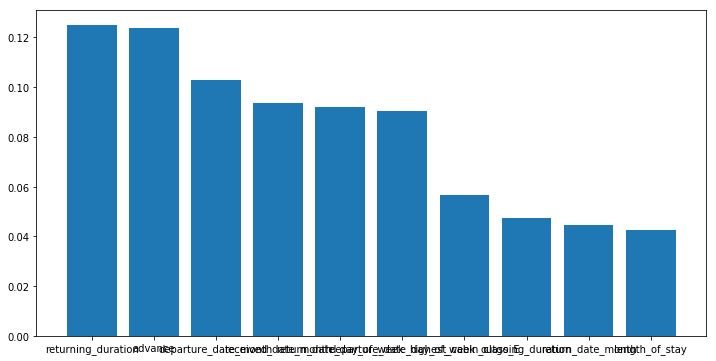

,test_predict,test_target
167574,409.350915,446.68
131617,373.805421,372.19
7449,374.739530,331.68
99861,312.502881,325.43
51091,526.266246,575.69
115169,319.068900,299.91
18666,931.605092,917.80
85176,686.970366,661.24
144960,469.236916,469.48
55414,551.676048,854.19


In [781]:
test_predict = model.predict(test_features)
train_predict = model.predict(train_features)


def rmse(y_true,y_pred):
    return np.sqrt(sklearn.metrics.mean_squared_error(y_true,y_pred))

print(rmse(test_target,test_predict))

# plot_features(model,(10,14))
feature_importances = model.feature_importances_
importance_table = pd.DataFrame(feature_importances, index=train_features.columns, 
                          columns=["Importance"]).sort_values(by=['Importance'],ascending=False)
importance_table['Importance'] = round(importance_table['Importance'],4)
print(importance_table.head(20))

# ***visualize top 10 or more predictors
x_bar = set(importance_table.index[0:10])
y_bar = importance_table['Importance'][0:10]
ind = [x for x, _ in enumerate(x_bar)]
plt.rcParams['figure.figsize'] = [12, 6]

plt.bar(ind,y_bar)
plt.xticks(ind,x_bar)
plt.show()


compare = pd.DataFrame()
compare['test_predict'] = test_predict
compare['test_target'] = np.array(test_target)

# test_target
compare.sample(20)

### Generate Predicted Price Distribution and Lift Curves:
A lift curve visualizes risk: first, it sorts all predicted-actual pairs by predicted value; second, it groups these pairs into x (in this case 30) evenly counted buckets; finally, it calculates and plots the mean of each predicted and actual price for each bucket.


Distribution of Predicted Flight Costs:


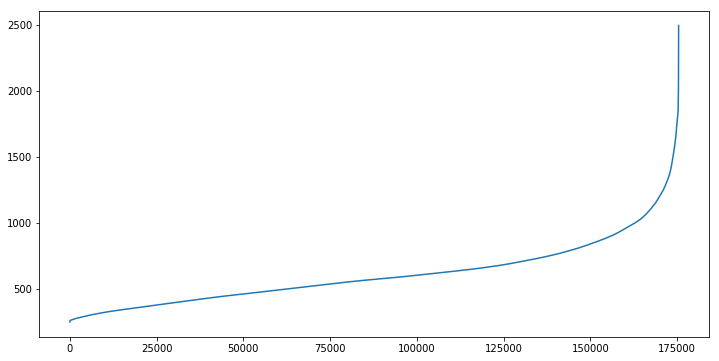

sum check: 107960182.0935 

sum check: 107860193.93 

total_usd
0      272.916923
1      298.066710
2      319.669355
3      340.797250
4      359.395732
5      378.181178
6      399.265882
7      420.701224
8      440.918709
9      460.070407
10     476.288092
11     494.060169
12     514.030896
13     536.276752
14     556.684884
15     572.136428
16     588.632164
17     604.909012
18     624.602656
19     645.052002
20     668.996200
21     695.555365
22     726.566866
23     761.521859
24     806.249538
25     859.164015
26     924.022066
27    1013.001581
28    1160.595361
29    1524.300150
Name: total_usd, dtype: float64 0      286.109534
1      319.400494
2      343.857257
3      364.634673
4      385.490368
5      406.049646
6      426.434576
7      445.959900
8      463.462663
9      480.859925
10     498.680479
11     516.745432
12     534.443115
13     551.676072
14     567.407166
15     581.714856
16     596.276715
17     612.537777
18     629.010453
19     646.101948
20  

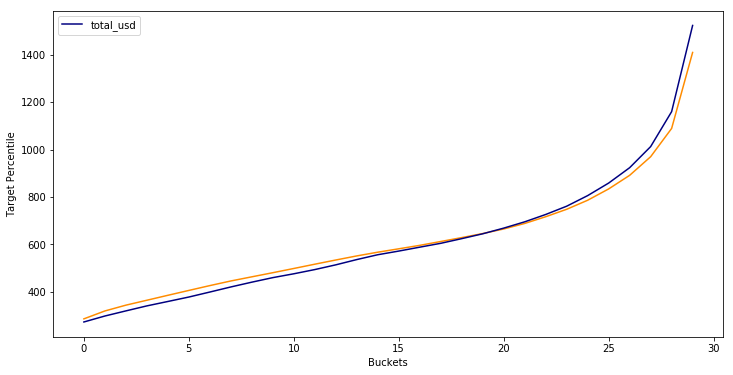

In [798]:
curve = np.sort(test_predict)
# curve = np.sort(test_target)
plt.plot(curve)
print("Distribution of Predicted Flight Costs:")
plt.show()

print("sum check:",round(test_predict.sum(),4),'\n')
print("sum check:",round(test_target.sum(),4),'\n')


def LiftCurve(actual, predicted, bins):
    actual_ranks = pd.qcut(actual.rank(method='first'),bins,labels=False)
    pred_ranks = pd.qcut(predicted.rank(method='first'),bins,labels=False)
    actual_percentiles = actual.groupby(actual_ranks).mean()
    pred_percentiles = predicted.groupby(pred_ranks).mean()
    
    
#     plt.title('Lift Chart')
    plt.plot(pred_percentiles,color='darkorange')
    plt.plot(actual_percentiles,color='navy')
    plt.ylabel('Target Percentile')
    plt.xlabel('Buckets')
    plt.legend(loc='best') 
    print(actual_percentiles,pred_percentiles)

    
LiftCurve(test_target,pd.Series(test_predict),30)
    

## V: Run Pricing Recommendation Algorithm on Randomly Generated Flight:
Buy flight if current price is in the top 20% of future predicted flight prices. 
Scoring for each day - pick test search_id and run for every day or every 3 days for up to 8 months

In [804]:
# Generate random search_id and trip_index to use
random_flight = test_features_simulate.loc[:,['search_id','trip_index']].sample(1)
random_search_id = random_flight.iloc[0,0]
random_trip_index = random_flight.iloc[0,1]
print("Random Search ID:", random_search_id)
# print(random_trip_index)

# begin creating single flight scoring simulation
test_features_simulate = test_features.copy()
# print(test_features_simulate.shape)
test_features_simulate['search_id'] = flights_test['search_id']
test_features_simulate['total_usd'] = flights_test['total_usd']
test_features_simulate['trip_index'] = flights_test['trip_index']
# print(test_features_simulate.shape)

# search_id = '3ac1c217-92ea-3d99-b705-cbd3e6639006'
search_id = random_search_id
# trip_index = 57
trip_index = random_trip_index

test_features_simulate_single = test_features_simulate[(test_features_simulate['search_id'] == search_id)
                                                      & (test_features_simulate['trip_index'] == trip_index)
                                                      ]
original_price = test_features_simulate_single.loc[:,'total_usd'].iloc[0]                                                 
# print(test_features_simulate_single.head())
test_features_simulate_single_score = test_features_simulate_single.drop(['total_usd','search_id','trip_index'],axis=1)


original_advance = test_features_simulate_single.loc[:,'advance'].iloc[0]
test_features_simulate_single_score.loc[:,'advance'].iloc[0] = original_advance
print("Original Advance # of Days:",original_advance)

def score_flight():
    global predict_price
    global advance_value
    global low_threshold       
    predict_price = pd.Series()
        
    while test_features_simulate_single_score.loc[:,'advance'].iloc[0] > 14:
        predict_price = predict_price.append(pd.Series(model.predict(test_features_simulate_single_score)))
        test_features_simulate_single_score.loc[:,'advance'].iloc[0] = test_features_simulate_single_score.loc[:,'advance'].iloc[0] - 3
        advance_value = test_features_simulate_single_score.loc[:,'advance'].iloc[0]
    else: 
        if original_advance <= 14:
            print("Departure date is less than two weeks away: No recommendation!")
        else:
            low_threshold = round(np.percentile(predict_price,20),2)
            if low_threshold <= original_price:
                print("Original Flight Price:",original_price)
                print("Future Low 20% Threshold:",low_threshold)
                print('WAIT')
            else:
                print("Original Flight Price:",original_price)
                print("Low Future Threshold:",low_threshold)
                print('BUY')

score_flight()
# print(advance_value)
# print(predict_price)
# print(low_threshold)
# print("Original Flight Price:",original_price)
# print("Low Future Threshold:",low_threshold)


Random Search ID: d355870f-a142-325d-ab4e-dad4e5698a8b
Original Advance # of Days: 34
Original Flight Price: 635.97
Future Low 20% Threshold: 604.11
WAIT
